# Metric Learning Homework

### Author: Denys Herasymuk

This notebook includes evaluation for the third and fourth models (two versions) in the homework:
* Fine-tuned using ArcFace Loss
* Fine-tuned using Siamese approach and Custom Contrastive Loss
* Fine-tuned using Siamese approach and Contrastive Loss from pytorch-metric-learning library

In [ ]:
from IPython.display import Image, HTML, clear_output
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install libraries

In [ ]:
# !pip install pytorch-metric-learning
# !pip install faiss-gpu
# clear_output()

In [ ]:
# !pip install albumentations
# !pip install annoy
# !pip install ml_metrics
# clear_output()

## Download dataset

In [ ]:
# !wget --load-cookies /tmp/cookies.txt "https://drive.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=1TclrpQOF_ullUP99wk_gjGN8pKvtErG8' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1TclrpQOF_ullUP99wk_gjGN8pKvtErG8" -O stanford_online_products.zip && rm -rf /tmp/cookies.txt

--2022-12-23 18:33:02--  https://drive.google.com/uc?export=download&confirm=t&id=1TclrpQOF_ullUP99wk_gjGN8pKvtErG8
Resolving drive.google.com (drive.google.com)... 74.125.196.101, 74.125.196.100, 74.125.196.139, ...
Connecting to drive.google.com (drive.google.com)|74.125.196.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-b4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/iq7cljahsu4gddmqlcrf71k4rhhp5rbm/1671820350000/04043966070551577705/*/1TclrpQOF_ullUP99wk_gjGN8pKvtErG8?e=download&uuid=d6432b4f-8d2f-4318-94c1-992033e28a9f [following]
--2022-12-23 18:33:02--  https://doc-0s-b4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/iq7cljahsu4gddmqlcrf71k4rhhp5rbm/1671820350000/04043966070551577705/*/1TclrpQOF_ullUP99wk_gjGN8pKvtErG8?e=download&uuid=d6432b4f-8d2f-4318-94c1-992033e28a9f
Resolving doc-0s-b4-docs.googleusercontent.com (doc-0s-b4-docs.googleusercontent.com)... 173.194.217

In [ ]:
# !unzip ./stanford_online_products.zip
# clear_output()

In [ ]:
# !git clone https://github.com/denysgerasymuk799/UCU_CV_Metric_Learning_HW.git

Cloning into 'UCU_CV_Metric_Learning_HW'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 77 (delta 39), reused 59 (delta 21), pack-reused 0
Unpacking objects: 100% (77/77), done.


In [ ]:
# !git pull

## Import libraries

In [ ]:
import cv2
import random
import numpy as np
import pandas as pd
import albumentations as albu
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2 as ToTensor
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [ ]:
repo_path = '/content/UCU_CV_Metric_Learning_HW'
if os.getcwd() != repo_path:
  os.chdir(repo_path)
  print('Current working dir: ', os.getcwd())

Current working dir:  /content/UCU_CV_Metric_Learning_HW


In [ ]:
from src.data_preparation.prepare_datasets import get_data_transforms, get_files_metadata_dfs, get_datasets, get_data_loaders
from src.models.model_types import ModelTypes
from src.models.resenet_initializer import ResNetInitializer
from src.utils.annoy_utils import get_embedding, build_index, load_index
from src.utils.viz_utils import normalized_img_tensor_to_rgb, show_img, show_retrieval
from src.utils.fine_tuning import complex_criterion, fine_tune_model, fine_tune_arcface
from src.utils.model_evaluation import evaluate

## Define configs

In [ ]:
SEED = 42
VAL_FRACTION = 0.2
BATCH_SIZE = 64
NUM_WORKERS = 16
METRICS_K = 5

INDEX_MODEL_OUTPUT_SIZE = 512  # Length of item vector that will be indexed

ROOT_DATA_DIR = '/content/Stanford_Online_Products'
GDRIVE_DATA_DIR = '/content/drive/MyDrive/UCU/4course_1term/Computer_Vision/Practice/Metric_Learning_HW1/results'

In [ ]:
models_metrics_df = pd.DataFrame(columns=[
    'Model_Name',
    'Accuracy_Class_ID',
    'Accuracy_Superclass_ID',
    f'mAP@{METRICS_K}_Class_ID',
    f'mAP@{METRICS_K}_Superclass_ID'
])

## Create data loaders

In [ ]:
files_metadata_dfs = get_files_metadata_dfs(ROOT_DATA_DIR, VAL_FRACTION, SEED)

Train shape:  (47640, 4)
Val shape:  (11911, 4)
Test shape:  (60502, 4)


In [ ]:
num_superclasses = max([len(files_metadata_dfs[phase]['super_class_id'].unique()) for phase in ['train', 'val', 'test']])
print('Number of superclasses: ', num_superclasses)
num_classes = max([len(files_metadata_dfs[phase]['class_id'].unique()) for phase in ['train', 'val', 'test']])
print('Number of classes: ', num_classes)

Number of superclasses:  12
Number of classes:  11318


In [ ]:
# shink_size = 200
# files_metadata_dfs['train'] = files_metadata_dfs['train'][:shink_size]
# files_metadata_dfs['val'] = files_metadata_dfs['val'][:shink_size]
# files_metadata_dfs['test'] = files_metadata_dfs['test'][:shink_size]

In [ ]:
datasets = get_datasets(files_metadata_dfs, ROOT_DATA_DIR)
data_loaders = get_data_loaders(datasets, BATCH_SIZE, NUM_WORKERS)
dataset_sizes = {
    'train': len(datasets['train']),
    'val': len(datasets['val']),
}

Class id: 908
Super Class id: 2



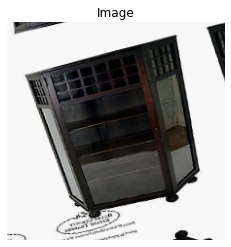

In [ ]:
show_img(datasets['train'], 4)

Class id: 11319
Super Class id: 1



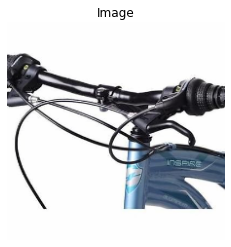

In [ ]:
show_img(datasets['test'], 4)

# Task 3: Fine-tuned using ArcFace Loss

In [ ]:
resnet18_arcface_conf = ResNetInitializer(ModelTypes.TUNED_WITH_ARCFACE, num_superclasses, num_classes, embedding_size=INDEX_MODEL_OUTPUT_SIZE)

### Fine-tune the model

In [ ]:
best_resnet18_arcface, optimizer_ft, class_loss_optimizer, superclass_loss_optimizer =\
   fine_tune_arcface(resnet18_arcface_conf.model, data_loaders, dataset_sizes,
                     resnet18_arcface_conf.class_criterion, resnet18_arcface_conf.class_loss_optimizer,
                     resnet18_arcface_conf.superclass_criterion, resnet18_arcface_conf.superclass_loss_optimizer,
                     resnet18_arcface_conf.optimizer, resnet18_arcface_conf.scheduler, num_epochs=4)

Epoch 0/3
----------


100%|██████████| 745/745 [04:52<00:00,  2.55it/s]



[train] Class Loss: 42.3100 Superclass Loss: 21.0287


100%|██████████| 187/187 [00:51<00:00,  3.61it/s]



[val] Class Loss: 41.8269 Superclass Loss: 19.4609

Epoch 1/3
----------


100%|██████████| 745/745 [04:43<00:00,  2.63it/s]



[train] Class Loss: 41.8071 Superclass Loss: 17.2873


100%|██████████| 187/187 [00:49<00:00,  3.74it/s]



[val] Class Loss: 41.6529 Superclass Loss: 18.8251

Epoch 2/3
----------


100%|██████████| 745/745 [04:40<00:00,  2.65it/s]



[train] Class Loss: 41.6334 Superclass Loss: 15.8548


100%|██████████| 187/187 [00:49<00:00,  3.77it/s]



[val] Class Loss: 41.5184 Superclass Loss: 17.3443

Epoch 3/3
----------


100%|██████████| 745/745 [04:40<00:00,  2.66it/s]



[train] Class Loss: 41.5192 Superclass Loss: 14.9466


100%|██████████| 187/187 [00:49<00:00,  3.78it/s]


[val] Class Loss: 41.4145 Superclass Loss: 15.4630

Training complete in 22m 18s
Best val Loss [Classes]: 41.414523
Bests val Loss [Superclasses]: 15.463033


In [ ]:
# Set model to evaluation mode
best_resnet18_arcface.eval()

checkpoint = {
    'state_dict': best_resnet18_arcface.state_dict(),
    'optimizer': optimizer_ft.state_dict(),
    'class_loss_optimizer': class_loss_optimizer.state_dict(),
    'superclass_loss_optimizer': superclass_loss_optimizer.state_dict(),
}
torch.save(checkpoint, f'{GDRIVE_DATA_DIR}/{resnet18_arcface_conf.model_name}_fine_tuned_checkpoint.pth')

### Build an Index

In [ ]:
annoy_index = build_index(best_resnet18_arcface, datasets['train'], INDEX_MODEL_OUTPUT_SIZE,
                          resnet18_arcface_conf.model_name, num_trees=12, data_dir=GDRIVE_DATA_DIR)
annoy_index.get_nns_by_item(0, 5)

100%|██████████| 47640/47640 [09:00<00:00, 88.13it/s]



Number of skipped images because of errors: 0
Number of successfully saved images: 47640


[0, 43856, 47486, 15707, 17741]

### Evaluate the model

Load the best model and optimizer from the last checkpoint

In [ ]:
resnet18_arcface_conf = ResNetInitializer(ModelTypes.TUNED_WITH_ARCFACE, num_superclasses, num_classes, embedding_size=INDEX_MODEL_OUTPUT_SIZE)
best_resnet18_arcface = resnet18_arcface_conf.model
last_checkpoint = torch.load(f'{GDRIVE_DATA_DIR}/{resnet18_arcface_conf.model_name}_fine_tuned_checkpoint.pth')
optimizer_ft = last_checkpoint['optimizer']
best_resnet18_arcface.load_state_dict(last_checkpoint['state_dict'])
best_resnet18_arcface.eval()

MultilabelClassifier(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [ ]:
annoy_index = load_index(INDEX_MODEL_OUTPUT_SIZE, resnet18_arcface_conf.model_name, datasets['train'], data_dir=GDRIVE_DATA_DIR)

In [ ]:
models_metrics_df = evaluate(best_resnet18_arcface, resnet18_arcface_conf.model_name, models_metrics_df,
                             datasets['train'], datasets['val'], annoy_index, METRICS_K)

100%|██████████| 11911/11911 [07:04<00:00, 28.09it/s]



[resnet18_with_arcface_loss] Accuracy for class_id: 0.171
[resnet18_with_arcface_loss] Accuracy for superclass_id: 0.7333
[resnet18_with_arcface_loss] mAP@5 for class_id: 0.1962
[resnet18_with_arcface_loss] mAP@5 for superclass_id: 0.7861


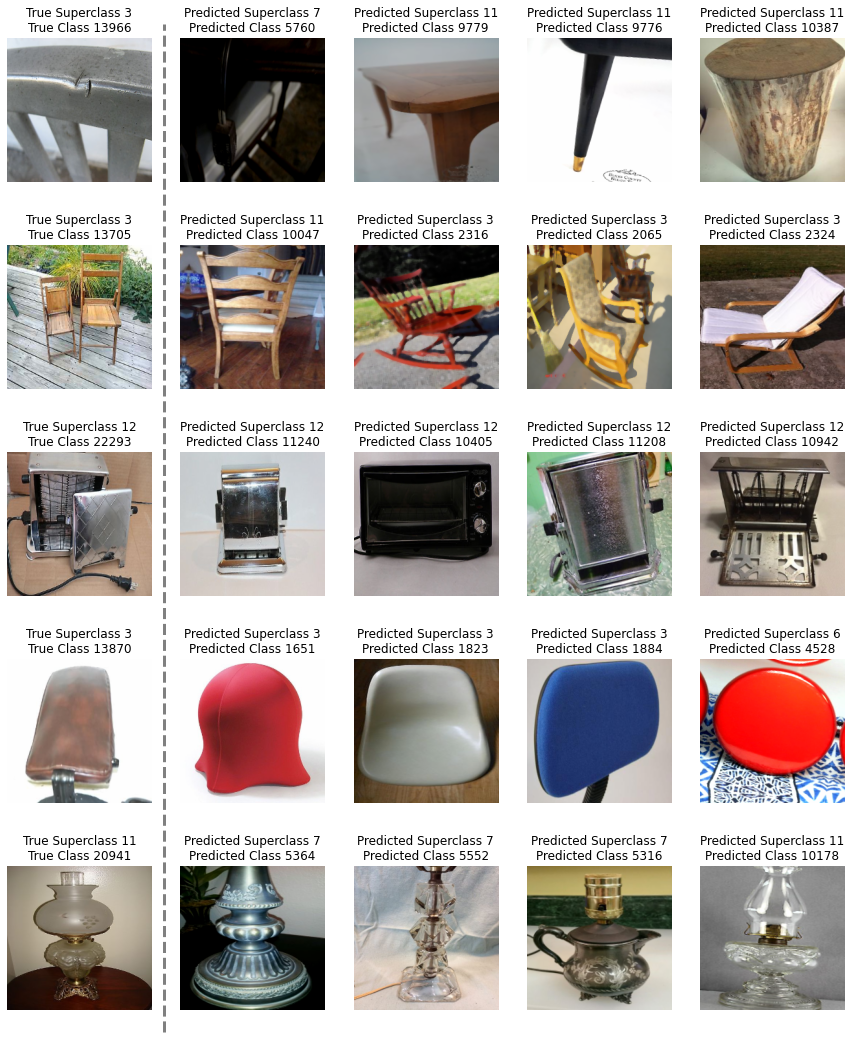

In [ ]:
show_retrieval(best_resnet18_arcface, annoy_index, datasets['train'], datasets['test'], k_closest=4)

In [ ]:
models_metrics_df

,Model_Name,Accuracy_Class_ID,Accuracy_Superclass_ID,mAP@5_Class_ID,mAP@5_Superclass_ID
0,resnet18_with_arcface_loss,0.171,0.7333,0.1962,0.7861


In [ ]:
models_metrics_df.to_csv(f'{GDRIVE_DATA_DIR}/{resnet18_arcface_conf.model_name}_models_metrics_df.csv', index=False)

# Task 4: Fine-tuned using Siamese approach and Contrastive Loss [Custom approach]

In [ ]:
from src.utils.fine_tuning import fine_tune_siamese
from src.data_preparation.prepare_datasets import create_siamese_datasets

In [ ]:
siamese_datasets = create_siamese_datasets(datasets)
siamese_data_loaders = get_data_loaders(siamese_datasets, BATCH_SIZE, NUM_WORKERS)

In [ ]:
custom_resnet18_siamese_conf = ResNetInitializer(ModelTypes.TUNED_SIAMESE_WITH_CUSTOM_CONTRASTIVE, num_superclasses, num_classes, embedding_size=64)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

## Fine-tune the model

In [ ]:
best_custom_resnet18_siamese, optimizer_ft = fine_tune_siamese(custom_resnet18_siamese_conf.model, siamese_data_loaders, dataset_sizes,
                                                                custom_resnet18_siamese_conf.criterion, custom_resnet18_siamese_conf.optimizer,
                                                                custom_resnet18_siamese_conf.scheduler, num_epochs=1)

Epoch 0/0
----------


100%|██████████| 745/745 [13:20<00:00,  1.07s/it]



[train] Class Loss: 1.9980 Superclass Loss: 1.9980


100%|██████████| 187/187 [02:42<00:00,  1.15it/s]


[val] Class Loss: 1.9854 Superclass Loss: 1.9854

Training complete in 16m 3s
Best val Loss [Classes]: 1.985376
Bests val Loss [Superclasses]: 1.985376


In [ ]:
# Set model to evaluation mode
best_custom_resnet18_siamese.eval()

checkpoint = {
    'state_dict': best_custom_resnet18_siamese.state_dict(),
    'optimizer': optimizer_ft.state_dict(),
}
torch.save(checkpoint, f'{GDRIVE_DATA_DIR}/{custom_resnet18_siamese_conf.model_name}_fine_tuned_checkpoint.pth')

## Build an Index

In [ ]:
annoy_index = build_index(best_custom_resnet18_siamese, datasets['train'], INDEX_MODEL_OUTPUT_SIZE,
                          custom_resnet18_siamese_conf.model_name, num_trees=12, data_dir=GDRIVE_DATA_DIR)
annoy_index.get_nns_by_item(0, 5)

100%|██████████| 47640/47640 [09:54<00:00, 80.13it/s]



Number of skipped images because of errors: 0
Number of successfully saved images: 47640


[0, 8488, 14377, 5536, 28449]

## Evaluate the model

Load the best model and optimizer from the last checkpoint

In [ ]:
custom_resnet18_siamese_conf = ResNetInitializer(ModelTypes.TUNED_SIAMESE_WITH_CUSTOM_CONTRASTIVE, num_superclasses, num_classes, embedding_size=64)
best_custom_resnet18_siamese = custom_resnet18_siamese_conf.model
last_checkpoint = torch.load(f'{GDRIVE_DATA_DIR}/{custom_resnet18_siamese_conf.model_name}_fine_tuned_checkpoint.pth')
optimizer_ft = last_checkpoint['optimizer']
best_custom_resnet18_siamese.load_state_dict(last_checkpoint['state_dict'])
best_custom_resnet18_siamese.eval()

MultilabelClassifier(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [ ]:
annoy_index = load_index(INDEX_MODEL_OUTPUT_SIZE, custom_resnet18_siamese_conf.model_name, datasets['train'], data_dir=GDRIVE_DATA_DIR)

In [ ]:
models_metrics_df = evaluate(best_custom_resnet18_siamese, custom_resnet18_siamese_conf.model_name, models_metrics_df,
                             datasets['train'], datasets['val'], annoy_index, METRICS_K)

100%|██████████| 11911/11911 [07:39<00:00, 25.94it/s]



[resnet18_siamese_with_custom_contrastive_loss] Accuracy for class_id: 0.3838
[resnet18_siamese_with_custom_contrastive_loss] Accuracy for superclass_id: 0.7812
[resnet18_siamese_with_custom_contrastive_loss] mAP@5 for class_id: 0.4156
[resnet18_siamese_with_custom_contrastive_loss] mAP@5 for superclass_id: 0.8306


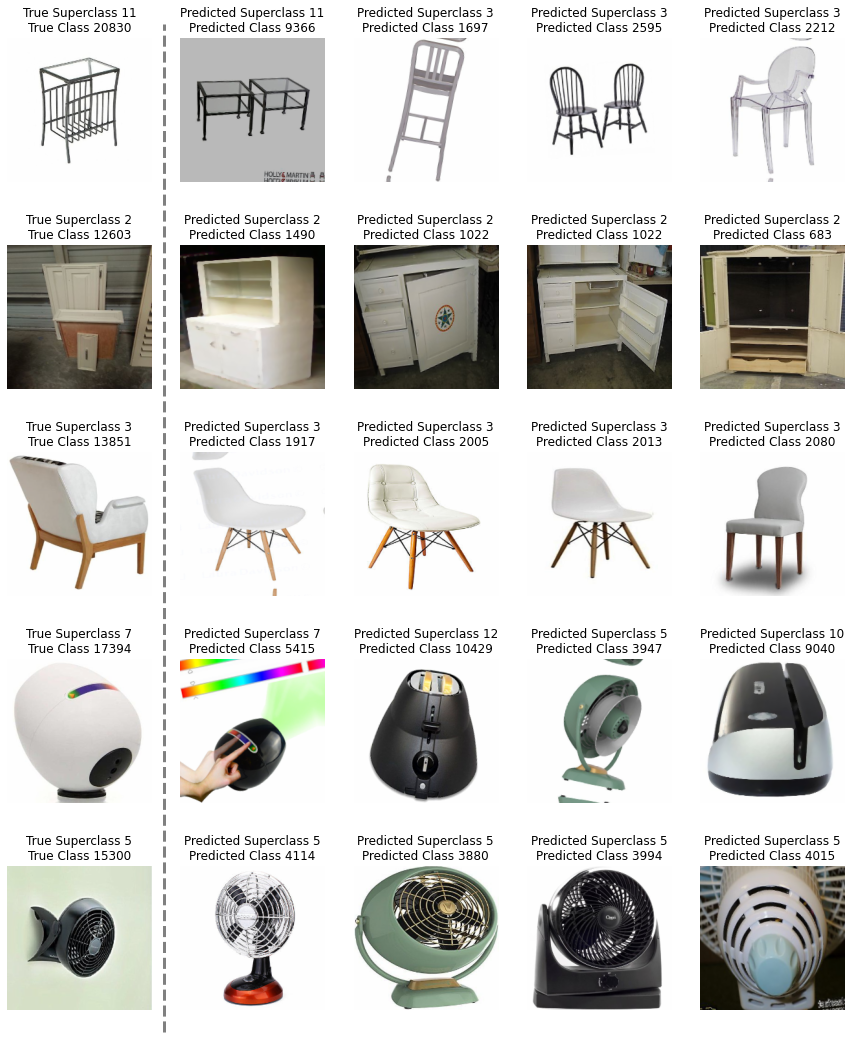

In [ ]:
show_retrieval(best_custom_resnet18_siamese, annoy_index, datasets['train'], datasets['test'], k_closest=4)

In [ ]:
models_metrics_df

,Model_Name,Accuracy_Class_ID,Accuracy_Superclass_ID,mAP@5_Class_ID,mAP@5_Superclass_ID
0,resnet18_siamese_with_custom_contrastive_loss,0.3838,0.7812,0.4156,0.8306


In [ ]:
models_metrics_df.to_csv(f'{GDRIVE_DATA_DIR}/{custom_resnet18_siamese_conf.model_name}_models_metrics_df.csv', index=False)

# Task 4: Fine-tuned using Siamese approach and Contrastive Loss [PyTorch Metric Learning Lib]

In [ ]:
resnet18_siamese_conf = ResNetInitializer(ModelTypes.TUNED_SIAMESE_WITH_CONTRASTIVE, num_superclasses, num_classes, embedding_size=INDEX_MODEL_OUTPUT_SIZE)

## Fine tune the model

Do NOT take accuracy scores below into account, since the last Linear layer for this model is set to embedding_size (=512), but not to num_classes or num_superclasses, which is required by the loss. I just reused the same fine-tuning function as for the first two models of the homework. And I understood that I did not need to compute accuracy for this model in such a way after analyzing results of all models. In any case, loss values are decreasing over time and final results with index retriaval are fine. 

In [ ]:
best_resnet18_siamese, optimizer_ft = fine_tune_model(resnet18_siamese_conf.model, data_loaders, dataset_sizes, resnet18_siamese_conf.criterion, 
                                                      resnet18_siamese_conf.optimizer, resnet18_siamese_conf.scheduler, num_epochs=4)

Epoch 0/3
----------


100%|██████████| 745/745 [04:19<00:00,  2.87it/s]



train Loss: 1.2570 Acc [Classes]: 0.0001 Acc [Superclasses]: 0.0026


100%|██████████| 187/187 [00:54<00:00,  3.41it/s]



val Loss: 1.0756 Acc [Classes]: 0.0002 Acc [Superclasses]: 0.0018

Epoch 1/3
----------


100%|██████████| 745/745 [04:17<00:00,  2.89it/s]



train Loss: 1.2093 Acc [Classes]: 0.0002 Acc [Superclasses]: 0.0031


100%|██████████| 187/187 [00:54<00:00,  3.43it/s]



val Loss: 1.0729 Acc [Classes]: 0.0002 Acc [Superclasses]: 0.0022

Epoch 2/3
----------


100%|██████████| 745/745 [04:19<00:00,  2.87it/s]



train Loss: 1.2329 Acc [Classes]: 0.0000 Acc [Superclasses]: 0.0028


100%|██████████| 187/187 [00:52<00:00,  3.59it/s]



val Loss: 1.0650 Acc [Classes]: 0.0001 Acc [Superclasses]: 0.0018

Epoch 3/3
----------


100%|██████████| 745/745 [04:17<00:00,  2.89it/s]



train Loss: 1.2206 Acc [Classes]: 0.0001 Acc [Superclasses]: 0.0026


100%|██████████| 187/187 [00:54<00:00,  3.44it/s]


val Loss: 1.0573 Acc [Classes]: 0.0002 Acc [Superclasses]: 0.0019

Training complete in 20m 50s
Best val Acc [Classes]: 0.000168
Bests val Acc [Superclasses]: 0.002183


In [ ]:
# Set model to evaluation mode
best_resnet18_siamese.eval()

checkpoint = {
    'state_dict': best_resnet18_siamese.state_dict(),
    'optimizer': optimizer_ft.state_dict(),
}
torch.save(checkpoint, f'{GDRIVE_DATA_DIR}/{resnet18_siamese_conf.model_name}_fine_tuned_checkpoint.pth')

## Build an Index

In [ ]:
annoy_index = build_index(best_resnet18_siamese, datasets['train'], INDEX_MODEL_OUTPUT_SIZE,
                          resnet18_siamese_conf.model_name, num_trees=12, data_dir=GDRIVE_DATA_DIR)
annoy_index.get_nns_by_item(0, 5)

100%|██████████| 47640/47640 [09:14<00:00, 85.90it/s]



Number of skipped images because of errors: 0
Number of successfully saved images: 47640


[0, 3386, 23483, 8488, 37506]

## Evaluate the model

Load the best model and optimizer from the last checkpoint

In [ ]:
resnet18_siamese_conf = ResNetInitializer(ModelTypes.TUNED_SIAMESE_WITH_CONTRASTIVE, num_superclasses, num_classes, embedding_size=INDEX_MODEL_OUTPUT_SIZE)
best_resnet18_siamese = resnet18_siamese_conf.model
last_checkpoint = torch.load(f'{GDRIVE_DATA_DIR}/{resnet18_siamese_conf.model_name}_fine_tuned_checkpoint.pth')
optimizer_ft = last_checkpoint['optimizer']
best_resnet18_siamese.load_state_dict(last_checkpoint['state_dict'])
best_resnet18_siamese.eval()

MultilabelClassifier(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [ ]:
annoy_index = load_index(INDEX_MODEL_OUTPUT_SIZE, resnet18_siamese_conf.model_name, datasets['train'], data_dir=GDRIVE_DATA_DIR)

In [ ]:
models_metrics_df = evaluate(best_resnet18_siamese, resnet18_siamese_conf.model_name, models_metrics_df,
                             datasets['train'], datasets['val'], annoy_index, METRICS_K)

100%|██████████| 11911/11911 [07:13<00:00, 27.50it/s]




[resnet18_siamese_with_contrastive_loss] Accuracy for class_id: 0.3842
[resnet18_siamese_with_contrastive_loss] Accuracy for superclass_id: 0.7879
[resnet18_siamese_with_contrastive_loss] mAP@5 for class_id: 0.4166
[resnet18_siamese_with_contrastive_loss] mAP@5 for superclass_id: 0.8342


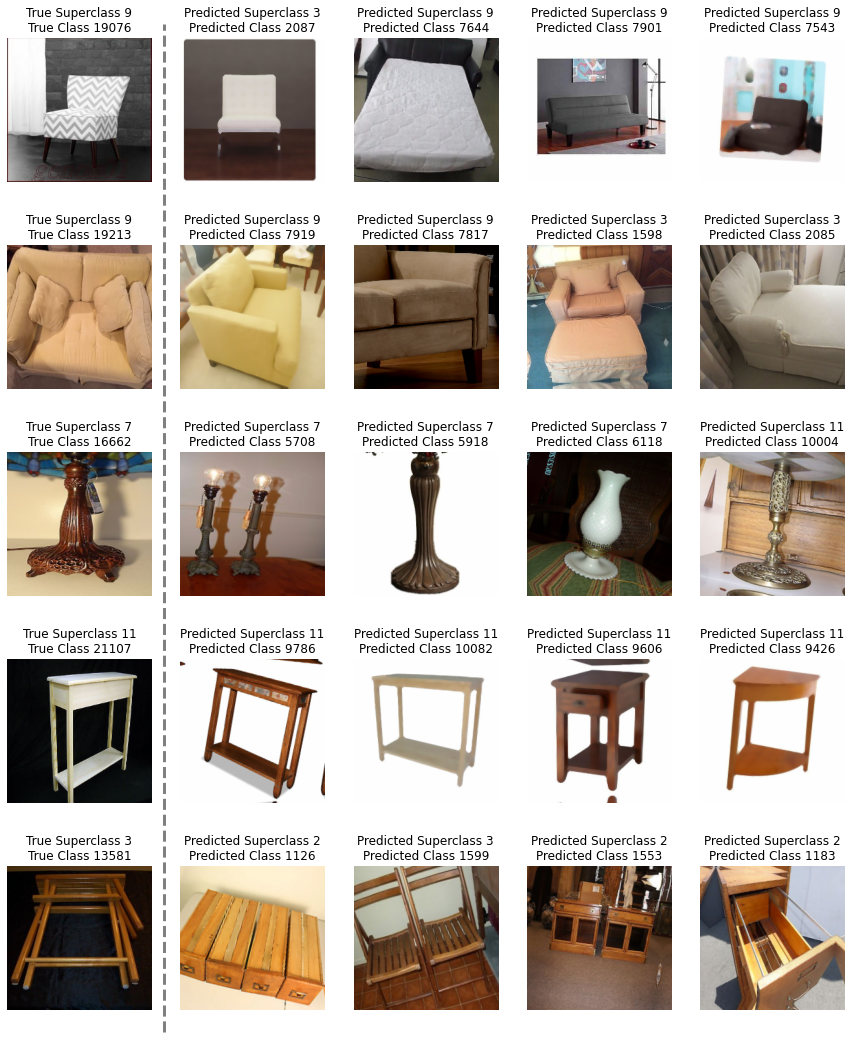

In [ ]:
show_retrieval(best_resnet18_siamese, annoy_index, datasets['train'], datasets['test'], k_closest=4)

In [ ]:
models_metrics_df

,Model_Name,Accuracy_Class_ID,Accuracy_Superclass_ID,mAP@5_Class_ID,mAP@5_Superclass_ID
0,resnet18_siamese_with_contrastive_loss,0.3842,0.7879,0.4166,0.8342


In [ ]:
models_metrics_df.to_csv(f'{GDRIVE_DATA_DIR}/{resnet18_siamese_conf.model_name}_models_metrics_df.csv', index=False)